# 평가(Evaluation) 

#### 머신러닝은 데이터 가공/변환, 모델 학습/예측, 평가의 프로세스로 구성된다.
#### 머신러닝 모델은 여러 가지 방법으로 예측 성능을 평가할 수 있다.
#### 성능 평가 지표(Evaluation Metric)는 일반적으로 분류냐 회귀냐에 따라 여러 종류로 나뉜다.
#### 회귀의 경우 대부분 실제 값과 예측 값의 오차 평균 값에 기반한다.
#### 분류의 평가 방법은 정확도만 가지고 판단했다가는 잘못된 평가 결과에 빠질 수 있다.
#### 이진 분류에서는 정확도보다 다른 성능 평가 지표가 더 중요시 된다.
#### 분류의 성능 평가 지표:
##### * 정확도(Accuracy)
##### * 오차행렬(Confusion Matrix)
##### * 정밀도(Precision)
##### * 재현율(Recall)
##### * F1 Score
##### * ROC AUC
#### 분류는 결정 클래스 값 종류의 유형에 따라 2개의 결과 값만을 가지는 이진 분류
#### 여러 개의 결정 클래스 값을 가지는 멀티 분류로 나뉠 수 있다.

## 01 정확도(Accuracy) 

In [1]:
# 정확도는 직관적으로 모델 예측 성능을 나타내는 평가지표이다.
# 하지만 이진 분류의 경우 데이터의 구성에 따라 ML 모델의 성능을 왜곡할 수 있기 떄문에
# 정확도 수치 하나만 가지고 성능을 평가하지 않는다.

In [56]:
import warnings
warnings.filterwarnings(action='ignore')
import sklearn
import numpy as np
import pandas as pd

In [57]:
# Customized 형태의 Estimator를 생성해보자.
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
    # fit() 메서드는 아무것도 학습하지 않음.
    def fit(self, X, y=None):
        pass
    # predict() 메서드는 단순히 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측함.
    def predict(self, X):
        pred = np.zeros((X.shape[0], 1))
        for i in range (X.shape[0]) :
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else:
                pred[i] = 1
        return pred

In [58]:
from sklearn.preprocessing import LabelEncoder

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 피처 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

# 레이블 인코딩 수행.
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [59]:
# 생성된 MyDummyClassifier를 이용해 타이타닉 생존자 예측을 수행해보자.
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할.
titanic_df = pd.read_csv('/Users/adam/Data_Analytics/Python/Datasets/titanic/train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df= titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test=train_test_split(X_titanic_df, y_titanic_df,
                                                  test_size=0.2, random_state=0)

# 위에서 생성한 Dummy Classifier를 이용해 학습/예측/평가 수행.
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print('Dummy Classifier의 정확도는: {0:.4f}'.format(accuracy_score(y_test, mypredictions)))

Dummy Classifier의 정확도는: 0.7877


In [60]:
# 이렇게 단순한 알고리즘으로 예측을 하더라도 데이터의 구성에 따라 정확도가 높게 나올 수 있기 때문에
# 정확도를 평가 지표로 사용할 떄는 매우 신중해야 한다.
# 특히 정확도는 불균형한 레이블 값 분포에서 ML 모델의 성능을 판단할 경우, 적합한 평가 지표가 아니다.

In [61]:
# MNIST 데이터 세트를 변환해 불균형한 데이터 세트로 만든 뒤에 정확도 지표 적용시 어떤 문제가 발생할 수 있는지 살펴보자.
# 아무것도 하지 않고 무조거 특정한 결과로 찍어도 데이터 분포도가 균일하지 않은 경우 높은 수치가 나타날 수 있는 것이 정확도의 맹점이다.

In [62]:
# 먼저 불균형한 데이터 세트와 Dummy Classifier를 생성하자.
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
    def fit(self,X,y):
        pass
    
    # 입력값으로 들어오는 X 데이터 셋의 크기만큼 모두 0값으로 만들어서 반환
    def predict(self,X):
        return np.zeros( (len(X), 1) , dtype=bool)

# 사이킷런의 내장 데이터 셋인 load_digits( )를 이용하여 MNIST 데이터 로딩
digits = load_digits()

print(digits.data)
print("### digits.data.shape:", digits.data.shape)
print(digits.target)
print("### digits.target.shape:", digits.target.shape)
digits.target == 7

# digits번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 7번이 아니면 False이고 0으로 변환. 
y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split( digits.data, y, random_state=11)

[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]
### digits.data.shape: (1797, 64)
[0 1 2 ... 8 9 8]
### digits.target.shape: (1797,)


In [63]:
# 불균형한 데이터로 생성한 y_test의 데이터 분포도를 확인하고 MyFakeClassifier를 이용해 예측과 평가를 수행해보자.

# 불균형한 레이블 데이터 분포도 확인.
print('레이블 테스트 세트 크기 :', y_test.shape)
print('테스트 세트 레이블 0 과 1의 분포도')
print(pd.Series(y_test).value_counts())

# Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train , y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는:{:.3f}'.format(accuracy_score(y_test , fakepred)))

레이블 테스트 세트 크기 : (450,)
테스트 세트 레이블 0 과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는:0.900


In [64]:
# 단순히 predict()dml rufrhkfmf np.zeros()로 모두 0값으로 반환함에도 불구하고 예측 정확도는 90%이다.
# 이처럼 정확도 평가 지표는 불균형한 레이블 데이터 세트에는 성능 수치로 사용돼서는 안된다.

## 02 오차 행렬 

In [65]:
# 이진 분류에서 성능 지표로 잘 활용되는 오차행렬(confusion matrix, 혼동행렬)은 학습된 분류 모델이
# 예측을 수행하면서 얼마나 햇갈리고 있는지도 함께 보여주는 지표이다.
# 즉, 이진 분류의 예측 오류가 얼마인지와 더불어 어떠한 유형의 예측 오류가 발생하고 있는지를 함께 나타내는 지표이다.
# TN, FP, FN, TP는 예측 클래스와 실제 클래스의 Positive 결정 값(값 1)과 Negative 결정 값(값 0)의 결합에 따라 결정된다.
# 앞 문자 True/False는 예측값과 실제값이 '같은가/틀린가'를 의미한다.
# 뒤 문자 Negative/Positive는 예측 결과 값이 부정(0)/금정(1)을 의미한다.
# TN: 예측값을 Negative 값 0으로 예측했고 실제 값 역시 Negative 값 0
# FP: 예측값을 Positive 값 1로 예측했는데 실제 값은 Negative 값 0
# FN: 예측값을 Negative 값 0으로 예측했는데 실제 값은 Positive 값 1
# TP: 예측값을 Positive 값 1로 예측했는데 실제 값 역시 Positive 값 1

In [66]:
# 사이킷런은 오차 행렬을 구하기 위해 confusion_matrix() API를 제공한다.

In [67]:
# 정확도 예제에서 다룬 MyFakeClassifier의 예측 성능 지표를 오차 행렬도 표현해보자.
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]])

In [68]:
# TP, TN, FP, FN 값은 Classifier 성능의 여러 면모를 판단할 수 있는 기반 정보를 제공한다.
# 이 값을 조합해 Classifier의 성능을 측정할 수 있는 주요 지표인 정확도, 정밀도, 재현율 값을 알 수 있다.

# 정확도 = 예측 결과와 실제 값이 동일한 건수/전체 데이터 수 = (TN + TP)/(TN + FP + FN + TP)

# 일반적으로 불균형한 레이블 클래스를 가진 이진 분류 모델에서는 많은 데이터 중에서 중점적으로 찾아야 하는 매우 적은 수의 결과값에
# Positive를 설정해 1값을 부여하고, 그렇지 않은 경우에는 Negative로 0 값을 부여하는 경우가 많다.

# 불균형한 이진 분류 데이터 세트에서는 Positive 데이터 건수가 매우 작기 떄문에 데이터에 기반한 ML 알고리즘은
# Positive보다는 Negative로 예측 정확도가 높아지는 경향이 발생한다.

## 03 정밀도와 재현율

In [69]:
# 정밀도와 재현율은 'Positive 데이터 세트'의 예측 성능에 좀 더 초첨을 맞춘 평가 지표이다.

# 정밀도 = TP / (FP + TP)
# 재현율(민감도, TPR) = TP / (FN + TP)

# 정밀도는 예측을 Positive로 한 대상 중에 실제 값이 Positive로 일치한 데이터의 비율을 뜻 한다.
# 재현율은 실제 값이 Positive인 대상 중에 실제 값이 Positive로 일치한 데이터의 비율을 뜻 한다.

# 정밀도와 재현율 지표 중에 이진 분류 모델의 업무 특성에 따라서 특정 평가 지표가 더 중요한 지표로 간주될 수 있다.

# 재현율이 더 중요 지표: '실제 Positive 양성'인 데이터 예측을 Negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우
# 예) 암 진단, 금융 사기 적발 등

# 정밀도가 더 중요한 지표: '실제 Negative 음성'인 데이터 예측을 Positive 양성으로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우
# 예) 스팸메일 여부 판단 등

# 재현율은 FN를 낮추는데, 정밀도는 FP를 낮추는 데 초점을 맞춘다.
# 재현율과 정밀도는 서로 보완적인 지표로 분류의 성능을 평가하는 데 적용.
# 가장 좋은 성능 평가는 재현율과 정밀도 모두 높은 수치를 얻는 것이다.

In [70]:
# 이번에는 타이타닉 예제에서 오차 행렬 및 정밀도, 재현율을 모두 구해서 예측 성능을 평가해보자.

In [71]:
# confusion matrix, accuracy, precision, recall 등의 평가를 한꺼번에 호출하는 get_clf_eval() 함수 만들기
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

In [72]:
# 로지스틱 회귀 기반 타이타닉 생존자 예측하고 confusion matrix, accuracy, precisin, recall 평가 수행 해보자.
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df = pd.read_csv('/Users/adam/Data_Analytics/Python/Datasets/titanic/train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=11)

lr_clf = LogisticRegression()

lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


### 정밀도/재현율 트레이드오프

In [73]:
# 분류하려는 업무의 특성상 정밀도 또는 재현율이 특별히 강조돼야 할 경우 분류의 결정 임곗값(Threshold)을 조정해
# 정밀도/재현율의 트레이드오프(Trade-off)라고 부른다.

# 사이킷런의 분류 알고리즘은 예측 데이터가 특정 레이블에 속하는지를 계싼하기 위해 먼저 개별 레이블별로 결정 확률을 구한다.
# 일반적으로 이진 분류에서는 이 임곗값을 0.5(50%)로 정하고 이 기준보다 확률이 크면 Positive, 작으면 Negative로 결정한다.

# 이진 분류에서 predict_proba()를 수행해 반환되는 ndarray는 첫 번째 칼럼이 클래스 값 0 예측 확률, 두 번째 칼럼이 클래스 값 1 예측 확률 이다.

In [75]:
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba()결과 Shape: {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:', pred_proba[:3])

# 예측 확률 array와 예측 결과값 array를 병합(concatenate)해 예측 확률과 결과값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1, 1)], axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3])

pred_proba()결과 Shape: (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.46200473 0.53799527]
 [0.87859951 0.12140049]
 [0.87714456 0.12285544]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.46200473 0.53799527 1.        ]
 [0.87859951 0.12140049 0.        ]
 [0.87714456 0.12285544 0.        ]]


In [76]:
# 반환 결과인 ndarray는 0과 1에 대한 확률을 나타내므로 첫 번째 칼럼 값과 두 번째 칼럼 값을 더하면 1이 된다.
# predict()는 predict_proba() 호출 결과로 반환된 배열에서 분류 결정 임계값보다
# 큰 값이 들어 있는 칼럼의 위치를 받아서 최종적으로 예측 클래스를 결정한다.

In [77]:
# Binarizer 클래스의 사용법 익히기
# 입력된 ndarray의 값을 지정된 threshold보다 같거나 작으면 0값으로, 크면 1 값으로 변환해 반환한다.
from sklearn.preprocessing import Binarizer

X = [[1, -1, 2],
    [2, 0, 0],
    [0, 1.1, 1.2]]

# X의 개별 원소들이 threshold 값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [78]:
# 이 Binarizer를 이용해 사이킷런 predict()의 의사(pseudo) 코드를 만들어보자.
from sklearn.preprocessing import Binarizer

# Binarizer의 threshold 설정값. 분류 결정 임곗값임.
custom_threshold = 0.5

# predict_proba( ) 변환값의 두 번째 칼럼, 즉 Positive 클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


In [80]:
# Binarizer의 threshold 설정값을 0.4로 설정. 즉 분류 결정 임곗값을 0.5에서 0.4로 낮춤
custom_threshold = 0.4
pred_proba_1 = pred_proba[: ,1].reshape(-1,1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361


In [81]:
# 분류 결정 임곗값은 Positive 예측값을 결정하는 확률의 기준이 된다.

In [83]:
# 임곗값을 0.4에서 0.6까지 0.05씩 증가시키며 평가 지표를 조사하기 위해, get_eval_by_threshold() 함수를 만들어 보자.
# 테스트 수행할 모든 임곗값을 리스트 객체로 저장.
thresholds = [0.4, 0.45, 0.5, 0.55, 0.60]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # thresholds list객체 내의 값을 차례로 iteration 하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:', custom_threshold)
        get_clf_eval(y_test, custom_predict)
        
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1, 1), thresholds)

임곗값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361
임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033
임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869
임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541
임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377


In [90]:
# precision_recall_curve()를 이용해 타이타닉 예측 모델의 임곗값별 정밀도와 재현율을 구해보자.
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일때의 예측 확률을 추출 
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1] 

# 실제값 데이터 셋과 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력 
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1 )
print('반환된 분류 결정 임곗값 배열의 Shape:', thresholds.shape)

#반환된 임계값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임곗값을 15 Step으로 추출. 
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값: ', np.round(thresholds[thr_index], 2))

# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값 
print('샘플 임계값별 정밀도: ', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율: ', np.round(recalls[thr_index], 3))

반환된 분류 결정 임곗값 배열의 Shape: (165,)
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135 150]
샘플용 10개의 임곗값:  [0.01 0.09 0.11 0.13 0.15 0.23 0.35 0.5  0.63 0.75 0.89]
샘플 임계값별 정밀도:  [0.341 0.372 0.415 0.448 0.505 0.585 0.688 0.774 0.913 0.935 0.938]
샘플 임계값별 재현율:  [1.    1.    0.967 0.918 0.902 0.902 0.869 0.787 0.689 0.475 0.246]


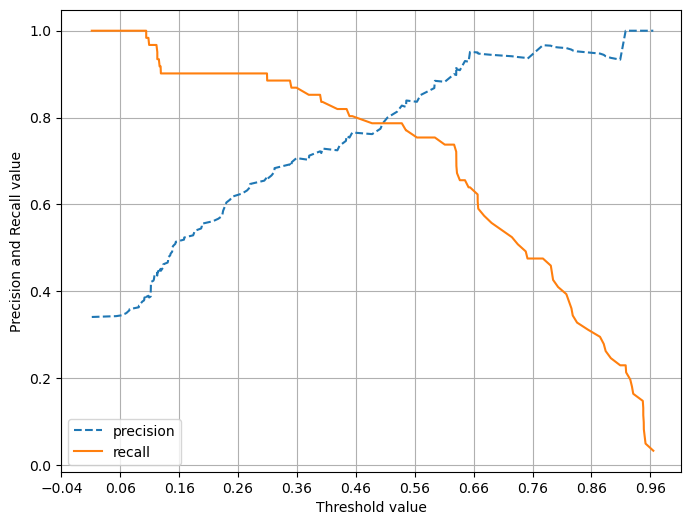

In [96]:
# 정밀도와 재현율의 임곘값에 따른 값 변화를 곡선 형태의 그래프로 시각화 하기
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:, 1] )

In [97]:
# 임곗값이 약 0.47 지점에서 재현율과 정밀도가 비슷해지는 모습을 보여준다.

## 정밀도와 재현율의 맹점 

In [ ]:
# Positive 예측의 임곗값을 변경함에 따라 정밀도와 재현율의 수치가 변경된다.
# 임곗값의 이러한 변경은 업무 환경에 맞게 두 개의 수치를 상호 보완할 수 있는 수준에서 적용돼야 한다.
# 그렇지 않고 단순히 하나의 성능 지표 수치를 높이기 위한 수단으로 사용해서는 안된다.

## 04 F1 스코어

In [98]:
# F1 스코어는 정밀도와 재현율을 결합한 지표이다.

In [99]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print('F1 스코어: {0:.4f}'.format(f1))

F1 스코어: 0.7805


In [104]:
# 타이타닉 생존자 예측에서 임곗값을 변화시키면서 F1 스코어를 포함한 평가 지표 구하기

def get_clf_eval(y_test , pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    # F1 스코어 추가
    f1 = f1_score(y_test,pred)
    print('오차 행렬')
    print(confusion)
    # f1 score print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}'.format(accuracy, precision, recall, f1))

thresholds = [0.4 , 0.45 , 0.50 , 0.55 , 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361, F1:0.7727
임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033, F1:0.7840
임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869, F1:0.7805
임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541, F1:0.7931
임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377, F1:0.8036


## 05 ROC 곡선과 AUC

In [106]:
# ROC 곡선과 이에 기반한 AUC 스코어는 이진 분류의 예측 성능 측정에서 중요하게 사용되는 지표이다.
# ROC 곡선은 FPR(False Positive Rate)이 변할 때 TPR(True Positive Rate)이 어떻게 변하는지 나타내는 곡선이다.
# FPR을 X 축, TPR을 Y축으로 잡으면 FPR의 변화에 따른 TPR의 변화가 곡선 형태로 나타난다.

# 민감도에 대응하는 지표로 TNR(Trune Negative Rate)라고 불리는 특이성(Specificity)가 있다.
# 특이성(TNR)dms 실제값 Negative(음성)가 정확히 예측돼야 하는 수준을 나타낸다.

# TNR = TN / (FP + TN) 
# FPR = FP / (FP + TN) = 1 - TNR = 1 - 특이성

# ROC 곡선이 가운데 직선에서 멀어질수록 성능이 뛰어난 것이다.
# ROC 곡선은 임계값을 1부터 0까지 변화시키면서 FPR을 구하고, 이 FPR값의 변화에 따른 TPR 값을 구하는 것이다.

from sklearn.metrics import roc_curve

# 레이블 값이 1일떄의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
# 반환된 임곗값 배열에서 샘플로 데이터를 추출하되, 임곗값을 5 step으로 추출.
# thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index:', thr_index)
print('샘플 index로 추출한 임곗값:', np.round(thresholds[thr_index], 2))

# 5 step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR:', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR:', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index: [ 1  6 11 16 21 26 31 36 41 46 51]
샘플 index로 추출한 임곗값: [0.97 0.65 0.63 0.56 0.45 0.4  0.35 0.15 0.13 0.11 0.11]
샘플 임곗값별 FPR: [0.    0.017 0.034 0.076 0.127 0.169 0.203 0.466 0.585 0.686 0.797]
샘플 임곗값별 TPR: [0.033 0.639 0.721 0.754 0.803 0.836 0.885 0.902 0.934 0.967 0.984]


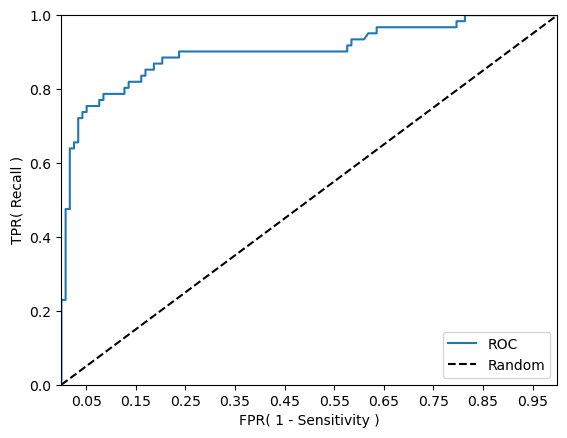

In [110]:
# FPR의 변화에 따른 TPR변화 ROC 곡선 시각화
def roc_curve_plot(y_test , pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환 받음. 
    fprs , tprs , thresholds = roc_curve(y_test ,pred_proba_c1)

    # ROC Curve를 plot 곡선으로 그림. 
    plt.plot(fprs , tprs, label='ROC')
    # 가운데 대각선 직선을 그림. 
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # FPR X 축의 Scale을 0.1 단위로 변경, X, Y축 명 설정 등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()
    
roc_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1] )

In [111]:
# AUC 값은 ROC 곡선 밑의 면적을 구한 것으로서 일반적으로 1에 가까울수록 좋은 수치이다.
# AUC 수치가 커지려면 FPR이 작은 상태에서 얼마나 큰 TPR을 얻을 수 있느냐가 관건이다.
# 보통의 분류는 0.5 이상의 AUC 값을 가진다.

In [114]:
from sklearn.metrics import roc_auc_score
pred_proba = lr_clf.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값: {0:.4f}'.format(roc_score))

ROC AUC 값: 0.9024


In [116]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
          F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))